<a href="https://colab.research.google.com/github/SanchayanDutta/Optimal-Question-Asking/blob/main/k_ary_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%writefile oqa_kary_oracle_dp.py
#!/usr/bin/env python3
# Exact k-ary oracle via DP under a uniform prior and noiseless answers.
# Usage:
#   python oqa_kary_oracle_dp.py --dataset /path/to/dataset.json
#   python oqa_kary_oracle_dp.py --dataset ... --save_tree /tmp/tree.json

import argparse, json
from functools import lru_cache
from typing import Dict, List, Any

def _bitcount(x: int) -> int:
    return x.bit_count()

def _ids_from_mask(mask: int, index2id: List[str]) -> List[str]:
    out, i = [], 0
    while mask:
        if mask & 1:
            out.append(index2id[i])
        mask >>= 1
        i += 1
    return out

class KaryOracleDP:
    def __init__(self, objects: Dict[str, Dict[str, str]]):
        # Canonical ordering of ids and attributes
        self.ids = sorted(objects.keys())
        self.n = len(self.ids)
        self.attrs = sorted({a for o in objects.values() for a in o})
        # Values per attribute that actually appear
        self.attr_values = {a: sorted({objects[i].get(a) for i in self.ids}) for a in self.attrs}

        # Map ids to bit positions
        self.id2idx = {oid: k for k, oid in enumerate(self.ids)}
        self.idx2id = self.ids[:]

        # Precompute masks for every (attr, value)
        self.mask_by_attr_val: Dict[str, Dict[str, int]] = {a: {} for a in self.attrs}
        for a in self.attrs:
            for v in self.attr_values[a]:
                m = 0
                for oid in self.ids:
                    if objects[oid].get(a) == v:
                        m |= 1 << self.id2idx[oid]
                self.mask_by_attr_val[a][v] = m

        self.root = (1 << self.n) - 1
        self._best_attr: Dict[int, str] = {}

    def _children(self, S: int, a: str) -> List[int]:
        """Non-empty proper children when splitting S by attribute a."""
        kids = []
        for v, mv in self.mask_by_attr_val[a].items():
            sub = S & mv
            if sub != 0 and sub != S:
                kids.append(sub)
        return kids

    @lru_cache(maxsize=None)
    def optimal_cost(self, S: int) -> float:
        """Minimal expected queries from candidate mask S (uniform prior)."""
        size = _bitcount(S)
        if size <= 1:
            return 0.0

        best = float("inf")
        best_a = None
        for a in self.attrs:
            parts = self._children(S, a)
            if len(parts) <= 1:
                continue
            exp_res = 0.0
            for child in parts:
                exp_res += (_bitcount(child)/size) * self.optimal_cost(child)
            cand = 1.0 + exp_res
            if cand < best:
                best, best_a = cand, a

        if best_a is None:
            # No remaining attribute can split S (irreducible equivalence class)
            self._best_attr[S] = ""
            return 0.0

        self._best_attr[S] = best_a
        return best

    def build_optimal_tree(self, S: int = None) -> Dict[str, Any]:
        """Reconstruct one optimal decision tree as a nested dict."""
        if S is None:
            S = self.root
        size = _bitcount(S)
        if size <= 1:
            return {"type": "leaf", "size": size, "ids": _ids_from_mask(S, self.idx2id)}
        a = self._best_attr.get(S, "")
        if not a:
            return {"type": "leaf", "size": size, "ids": _ids_from_mask(S, self.idx2id)}
        children = []
        for v, mv in self.mask_by_attr_val[a].items():
            child = S & mv
            if child == 0 or child == S:
                continue
            children.append({
                "value": v,
                "subset_size": _bitcount(child),
                "subtree": self.build_optimal_tree(child)
            })
        return {"type": "node", "attribute": a, "size": size, "children": children}

def main():
    ap = argparse.ArgumentParser(description="Optimal k-ary oracle (DP) for OQA datasets")
    ap.add_argument("--dataset", required=True, help="JSON file: {id: {attr: value}}")
    ap.add_argument("--save_tree", default=None, help="Optional path to save an optimal tree JSON")
    args = ap.parse_args()

    with open(args.dataset, "r") as f:
        objects = json.load(f)

    oracle = KaryOracleDP(objects)
    opt = oracle.optimal_cost(oracle.root)
    print(f"Objects: {oracle.n}, Attributes: {len(oracle.attrs)}")
    print(f"Optimal expected number of queries (uniform prior): {opt:.6f}")

    if args.save_tree:
        tree = oracle.build_optimal_tree()
        with open(args.save_tree, "w") as f:
            json.dump(tree, f, indent=2)
        print(f"Saved optimal tree to: {args.save_tree}")

if __name__ == "__main__":
    main()

Writing oqa_kary_oracle_dp.py


In [3]:
from google.colab import files
uploaded = files.upload()  # pick your dataset JSON(s) from local disk
list(uploaded.keys())

Saving oqa_kary100_dataset.json to oqa_kary100_dataset.json


['oqa_kary100_dataset.json']

In [4]:
!python -u oqa_kary_oracle_dp.py --dataset oqa_kary100_dataset.json --save_tree oqa_kary100_opt_tree.json

Objects: 100, Attributes: 8
Optimal expected number of queries (uniform prior): 3.310000
Saved optimal tree to: oqa_kary100_opt_tree.json


In [5]:
import json, pprint
with open("oqa_kary100_opt_tree.json") as f:
    tree = json.load(f)
# Show the root split and sizes
pprint.pprint({
    "root_attribute": tree.get("attribute", None),
    "root_size": tree.get("size", None),
    "children": [(c["value"], c["subset_size"]) for c in tree.get("children", [])]
})

{'children': [('fabric', 27),
              ('glass', 18),
              ('metal', 24),
              ('plastic', 17),
              ('wood', 14)],
 'root_attribute': 'material',
 'root_size': 100}


In [6]:
%%writefile oqa_kary_oracle_dp.py
#!/usr/bin/env python3
# Exact k-ary oracle via dynamic programming + per-turn curves.
# Dataset format: JSON mapping id -> {attr: value, ...}

import argparse, json, math
from functools import lru_cache
from typing import Dict, List, Any, Tuple

# ---------------- Utilities ----------------

def bitcount(x: int) -> int:
    return x.bit_count()

def ids_from_mask(mask: int, index2id: List[str]) -> List[str]:
    out, i = [], 0
    while mask:
        if mask & 1:
            out.append(index2id[i])
        mask >>= 1
        i += 1
    return out

# ---------------- Oracle ----------------

class KaryOracleDP:
    """
    Oracle for multi-valued (k-ary) attributes.
    Assumptions: uniform prior over objects, noiseless answers.
    """
    def __init__(self, objects: Dict[str, Dict[str, str]]):
        self.ids = sorted(objects.keys())
        self.n = len(self.ids)
        self.attrs = sorted({a for o in objects.values() for a in o.keys()})
        self.attr_vals = {a: sorted({objects[i].get(a) for i in self.ids}) for a in self.attrs}

        self.id2idx = {oid: k for k, oid in enumerate(self.ids)}
        self.idx2id = self.ids[:]

        # Precompute bitmasks for every (attr, value)
        self.mask_by_attr_val: Dict[str, Dict[str, int]] = {a: {} for a in self.attrs}
        for a in self.attrs:
            for v in self.attr_vals[a]:
                m = 0
                for oid in self.ids:
                    if objects[oid].get(a) == v:
                        m |= 1 << self.id2idx[oid]
                self.mask_by_attr_val[a][v] = m

        self.root = (1 << self.n) - 1
        self._best_attr: Dict[int, str] = {}

    # Split S into non-empty proper children for attribute a
    def _children(self, S: int, a: str) -> List[int]:
        kids = []
        for v, mv in self.mask_by_attr_val[a].items():
            sub = S & mv
            if sub != 0 and sub != S:
                kids.append(sub)
        return kids

    # Is S a leaf (|S|<=1 or no attribute yields a proper split)?
    def _is_leaf(self, S: int) -> bool:
        if bitcount(S) <= 1:
            return True
        for a in self.attrs:
            if len(self._children(S, a)) > 1:
                return False
        return True

    @lru_cache(maxsize=None)
    def optimal_cost(self, S: int) -> float:
        """Minimal expected queries from candidate mask S."""
        size = bitcount(S)
        if size <= 1:
            return 0.0

        best = float("inf")
        best_a = None
        for a in self.attrs:
            parts = self._children(S, a)
            if len(parts) <= 1:
                continue
            exp_res = 0.0
            for child in parts:
                exp_res += (bitcount(child) / size) * self.optimal_cost(child)
            cand = 1.0 + exp_res
            if cand < best:
                best, best_a = cand, a

        if best_a is None:
            # Irreducible equivalence class
            self._best_attr[S] = ""
            return 0.0

        self._best_attr[S] = best_a
        return best

    def build_optimal_tree(self, S: int = None) -> Dict[str, Any]:
        """Reconstruct one optimal tree."""
        if S is None:
            S = self.root
        size = bitcount(S)
        if size <= 1:
            return {"type": "leaf", "size": size, "ids": ids_from_mask(S, self.idx2id)}
        a = self._best_attr.get(S, "")
        if not a:
            return {"type": "leaf", "size": size, "ids": ids_from_mask(S, self.idx2id)}
        children = []
        for v, mv in self.mask_by_attr_val[a].items():
            child = S & mv
            if child == 0 or child == S:
                continue
            children.append({
                "value": v,
                "subset_size": bitcount(child),
                "subtree": self.build_optimal_tree(child)
            })
        return {"type": "node", "attribute": a, "size": size, "children": children}

    # --------- New: per-turn expected candidates and entropy curves ---------

    def expected_curve(self, max_turns: int = None) -> Dict[str, List[float]]:
        """
        Simulate the optimal policy as a distribution over states with absorbing leaves.
        Returns dict with lists aligned by dialog turn:
          - 'turn': [0, 1, ..., T]
          - 'E_candidates': E[|S_t|]
          - 'E_entropy_bits': E[log2 |S_t|]
          - 'leaf_mass': total probability mass already at leaves by turn t
        """
        # Ensure policy filled
        _ = self.optimal_cost(self.root)

        def entropy_bits(S: int) -> float:
            n = bitcount(S)
            return 0.0 if n <= 1 else math.log2(n)

        # Distribution over states at current turn: {mask -> prob}
        dist = {self.root: 1.0}
        turns, E_size, E_H, leaf_mass = [], [], [], []

        t = 0
        while True:
            # Record expectations at this turn
            turns.append(t)
            E_size.append(sum(p * bitcount(S) for S, p in dist.items()))
            E_H.append(sum(p * entropy_bits(S) for S, p in dist.items()))
            leaf_mass.append(sum(p for S, p in dist.items() if self._is_leaf(S)))

            # Stop if all mass is in leaves
            if leaf_mass[-1] >= 1.0 - 1e-12:
                break
            if max_turns is not None and t >= max_turns:
                break

            # Push distribution one step along the optimal policy
            next_dist: Dict[int, float] = {}
            for S, pS in dist.items():
                size = bitcount(S)
                if self._is_leaf(S):
                    # Absorbing
                    next_dist[S] = next_dist.get(S, 0.0) + pS
                    continue
                a = self._best_attr.get(S, "")
                if not a:
                    # Treat as absorbing if no split cached (safety)
                    next_dist[S] = next_dist.get(S, 0.0) + pS
                    continue
                parts = self._children(S, a)
                for child in parts:
                    w = pS * (bitcount(child) / size)
                    next_dist[child] = next_dist.get(child, 0.0) + w
            dist = next_dist
            t += 1

        return {
            "turn": turns,
            "E_candidates": E_size,
            "E_entropy_bits": E_H,
            "leaf_mass": leaf_mass
        }

# ---------------- CLI ----------------

def main():
    ap = argparse.ArgumentParser(description="Optimal k-ary oracle (DP) + per-turn curves")
    ap.add_argument("--dataset", required=True, help="JSON: {id: {attr: value}}")
    ap.add_argument("--save_tree", default=None, help="Optional JSON path for the optimal tree")
    ap.add_argument("--curve_csv", default=None, help="Optional CSV path for per-turn expectations")
    args = ap.parse_args()

    with open(args.dataset, "r") as f:
        objects = json.load(f)

    oracle = KaryOracleDP(objects)
    opt = oracle.optimal_cost(oracle.root)
    print(f"Objects: {oracle.n}, Attributes: {len(oracle.attrs)}")
    print(f"Optimal expected number of queries (uniform prior): {opt:.6f}")

    if args.save_tree:
        tree = oracle.build_optimal_tree()
        with open(args.save_tree, "w") as f:
            json.dump(tree, f, indent=2)
        print(f"Saved optimal tree to: {args.save_tree}")

    # Per-turn curve
    curve = oracle.expected_curve()
    print("\nPer-turn expectations (first few rows):")
    for i in range(min(6, len(curve['turn']))):
        print(f"t={curve['turn'][i]:2d}  "
              f"E[|S_t|]={curve['E_candidates'][i]:7.3f}  "
              f"E[H_t]={curve['E_entropy_bits'][i]:6.3f} bits  "
              f"leaf_mass={curve['leaf_mass'][i]:.3f}")

    if args.curve_csv:
        import csv
        with open(args.curve_csv, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["turn", "E_candidates", "E_entropy_bits", "leaf_mass"])
            for t, n, h, m in zip(curve["turn"], curve["E_candidates"], curve["E_entropy_bits"], curve["leaf_mass"]):
                w.writerow([t, n, h, m])
        print(f"Saved per-turn curve to: {args.curve_csv}")

if __name__ == "__main__":
    main()

Overwriting oqa_kary_oracle_dp.py


In [8]:
from google.colab import files
uploaded = files.upload()      # choose 'oqa_kary100_dataset.json' (and/or the 25-object file)
list(uploaded.keys())

Saving oqa_kary100_dataset.json to oqa_kary100_dataset.json


['oqa_kary100_dataset.json']

In [9]:
!python -u oqa_kary_oracle_dp.py \
  --dataset oqa_kary100_dataset.json \
  --save_tree oqa_kary100_opt_tree.json \
  --curve_csv oqa_kary100_oracle_curve.csv

Objects: 100, Attributes: 8
Optimal expected number of queries (uniform prior): 3.310000
Saved optimal tree to: oqa_kary100_opt_tree.json

Per-turn expectations (first few rows):
t= 0  E[|S_t|]=100.000  E[H_t]= 6.644 bits  leaf_mass=0.000
t= 1  E[|S_t|]= 21.140  E[H_t]= 4.363 bits  leaf_mass=0.000
t= 2  E[|S_t|]=  4.860  E[H_t]= 2.186 bits  leaf_mass=0.020
t= 3  E[|S_t|]=  1.500  E[H_t]= 0.423 bits  leaf_mass=0.670
t= 4  E[|S_t|]=  1.000  E[H_t]= 0.000 bits  leaf_mass=1.000
Saved per-turn curve to: oqa_kary100_oracle_curve.csv


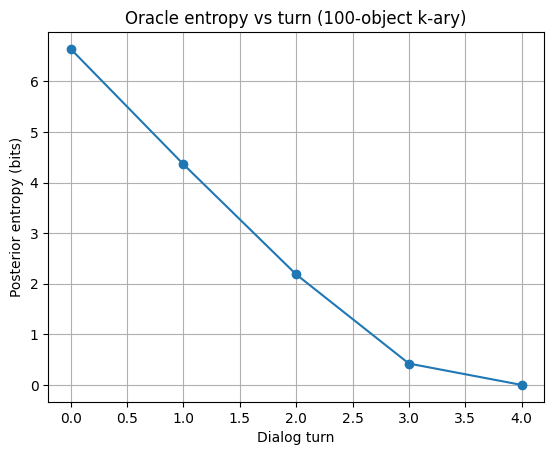

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

curve = pd.read_csv("oqa_kary100_oracle_curve.csv")
plt.figure()
plt.plot(curve["turn"], curve["E_entropy_bits"], marker="o")
plt.xlabel("Dialog turn")
plt.ylabel("Posterior entropy (bits)")
plt.title("Oracle entropy vs turn (100-object k-ary)")
plt.grid(True)
plt.show()